In [2]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [3]:
class sinDataLoader(Dataset):
    def __init__(self,start,end):
        self.start = start
        self.end = end
        self.pspace = np.arange(start,end+1)
    def return_sin_wave(self, sinmod=1, offset = np.pi*2,step = 1/1000):
        x = np.linspace(0,int(offset),int(1/step))
        y = np.sin(x*(sinmod*step))
        return y
    def __len__(self):
        return len(self.pspace)
    def __getitem__(self,index):
        return self.return_sin_wave(sinmod = self.pspace[index])

In [4]:
dl = DataLoader(sinDataLoader(0,3000),batch_size = 16,shuffle = True, num_workers = 4)

In [5]:
# plt.plot(next(iter(dl))[8])
next(iter(dl))[0].shape

torch.Size([1000])

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch


In [7]:
in_shape = 1000

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_shape, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, inp):
        validity = self.model(inp)
        return validity


In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(1, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, in_shape),
            nn.Tanh()
        )
    def forward(self,inp):
            return self.model(inp)


In [10]:
k = 2
p = 6
cuda = torch.cuda.is_available()

In [11]:
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()


In [12]:

optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [13]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [14]:
batches_done = 0
n_epochs = 100
for epoch in range(n_epochs):
    for i, imgs in enumerate(dl):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(
            0, 1, (imgs.shape[0], 1))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(
            Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(
            real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(
            Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(
            fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + \
            torch.mean(fake_validity) + div_gp

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        # -----------------
        #  Train Generator
        # -----------------

        # Generate a batch of images
        fake_imgs = generator(z)
        # Loss measures generator's ability to fool the discriminator
        # Train on fake images
        fake_validity = discriminator(fake_imgs)
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()

        print(
            "\r\n\t[Epoch {epoch/10}/{n_epochs}] [Batch {i}/{len(dl)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]",flush=True, end = "\r"
        )
        batches_done += 1
    print()
    print(f"\rEpoch {epoch+1}\n")


Epoch 11/100] [Batch 187/188] [D loss: -5.497149] [G loss: -0.255845]
Epoch 22/100] [Batch 187/188] [D loss: -6.517570] [G loss: -1.295716]
Epoch 33/100] [Batch 187/188] [D loss: -3.256652] [G loss: 1.933977]]
Epoch 44/100] [Batch 187/188] [D loss: -7.474131] [G loss: 2.594602]]
Epoch 55/100] [Batch 187/188] [D loss: -5.362196] [G loss: 0.021520]3]
Epoch 66/100] [Batch 187/188] [D loss: -2.753903] [G loss: 0.397679]]
Epoch 77/100] [Batch 187/188] [D loss: -6.650046] [G loss: 2.066870]]
Epoch 88/100] [Batch 187/188] [D loss: -0.442137] [G loss: -2.739856]
Epoch 99/100] [Batch 187/188] [D loss: -3.183875] [G loss: 4.728973]]
Epoch 100/100] [Batch 187/188] [D loss: -4.659942] [G loss: 1.101963]]
Epoch 111/100] [Batch 187/188] [D loss: -0.644419] [G loss: -2.403024]
Epoch 122/100] [Batch 187/188] [D loss: -4.382155] [G loss: 1.068006]]
Epoch 133/100] [Batch 187/188] [D loss: -1.887473] [G loss: 0.040846]]
Epoch 144/100] [Batch 187/188] [D loss: -2.376831] [G loss: 1.454777]]
Epoch 155/100]

In [15]:
z = Variable(Tensor(np.random.normal(
    0, 1, (imgs.shape[0], 1))))

# Generate a batch of images
fake_imgs = generator(z)


In [16]:
fake_imgs.shape

torch.Size([9, 1000])

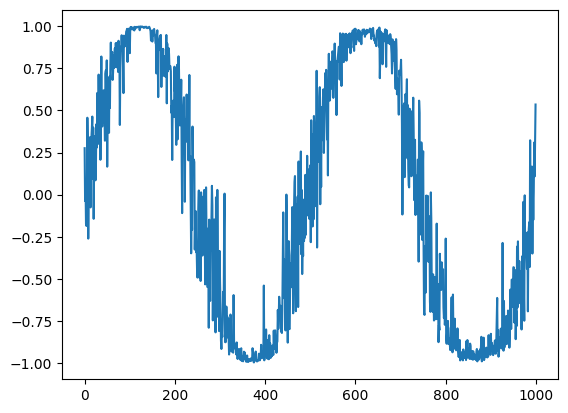

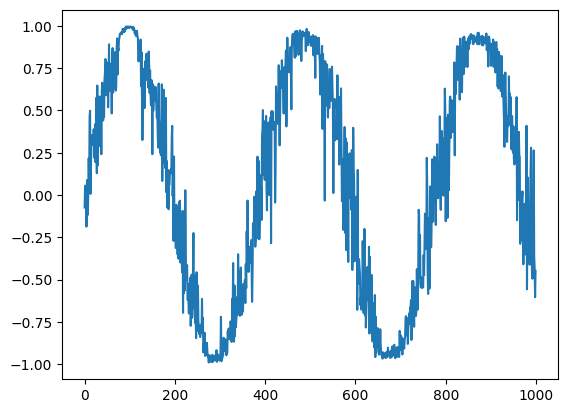

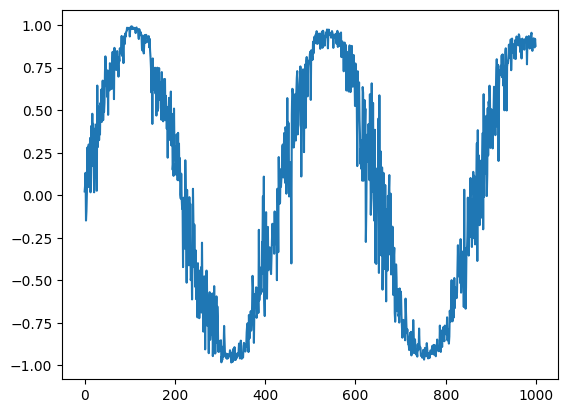

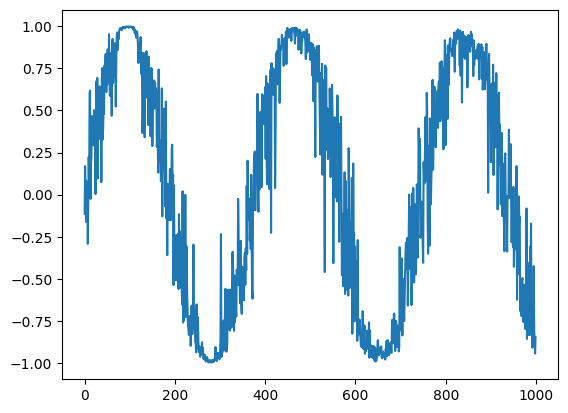

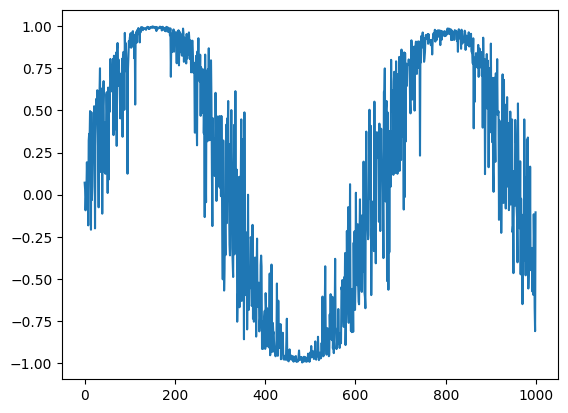

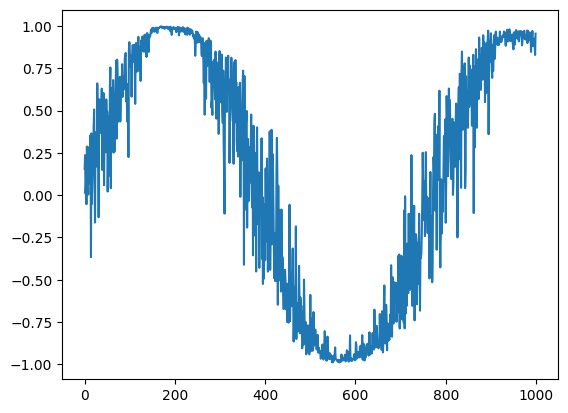

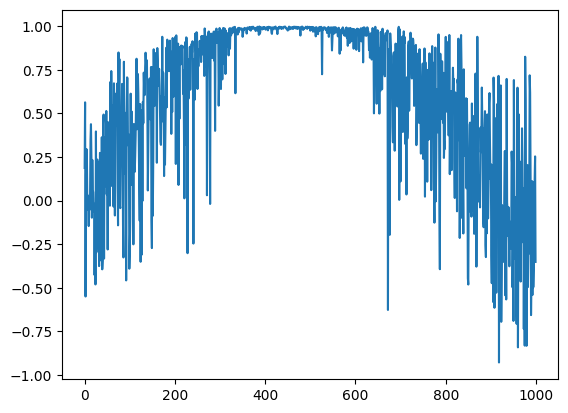

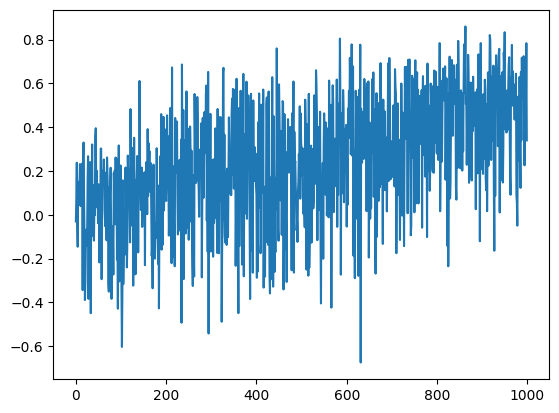

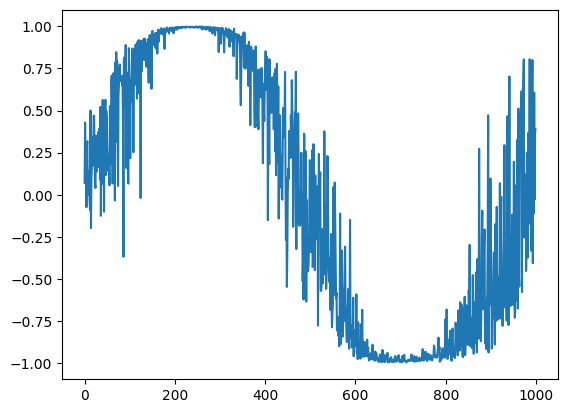

In [17]:
for i in range(fake_imgs.shape[0]):
    plt.plot(fake_imgs[i].detach().numpy())
    plt.show()